In [1]:
import re
import os
import jax
import pickle
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from rebayes.datasets import uci_uncertainty_data

In [4]:
dataset_path = "/home/gerardoduran/documents/external/DropoutUncertaintyExps/UCI_Datasets"

In [5]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [6]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)


def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)


def extract_data(files, base_path):
    regexp = re.compile("rank([0-9]+).pkl")
    data_all = {}
    for file in files:
        m = regexp.findall(file)
        if len(m) == 0:
            continue
            rank = 50
        else:
            rank = int(m[0])

        file_path = os.path.join(base_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        data_all[rank] = data
    return data_all



def extract_filenames(dataset, base_path):
    files = os.listdir(path)
    files_target = [file for file in files if (dataset in file) and ("pass" not in file)]
    return files_target


def build_df_summary(data, dataset_name):
    """
    Summary over the last-observed value
    """
    agent_last = jax.tree_map(lambda x: x[:, -1], data)
    df_summary = []
    for key in agent_last:
        piece = pd.DataFrame(agent_last[key])

        if key != 1:
            drop_cols = ["fdekf", "vdekf"]
            piece = piece.drop(drop_cols, axis=1)
        if key != 2:
            drop_cols = ["fcekf"]
            piece = piece.drop(drop_cols, axis=1)


        piece = piece.melt()
        piece["rank"] = key
        df_summary.append(piece)
    df_summary = pd.concat(df_summary).dropna(axis=0)
    df_summary = df_summary.query("variable != 'lofi_orth'")

    df_summary.loc[df_summary["variable"] == "fcekf", "rank"] = "full"
    df_summary.loc[df_summary["variable"] == "fdekf", "rank"] = 0
    df_summary.loc[df_summary["variable"] == "vdekf", "rank"] = 0
    df_summary = df_summary.assign(dataset=dataset_name)
    return df_summary

In [7]:
path = "./output/cross-validation"

In [8]:
order_cols = ["fcekf", "fdekf", "vdekf", "lofi", "lofi_diag", "lrvga", "sgd-rb"]

In [9]:
all_files = os.listdir(path)
datasets = list(set([f.split("_")[0].split(".")[0] for f in all_files]))

void_datasets = ["protein-tertiary-structure"]
datasets = [d for d in datasets if d not in void_datasets]
sorted(datasets)

['bostonHousing',
 'concrete',
 'energy',
 'kin8nm',
 'naval-propulsion-plant',
 'power-plant',
 'wine-quality-red',
 'yacht']

In [10]:
dataset = "yacht"
files_target = extract_filenames(dataset, path)
data_dataset = extract_data(files_target, path)
data_test = get_subtree(data_dataset, "test")
df_summary = build_df_summary(data_test, dataset)

In [11]:
methods_eval = ["lrvga", "sgd-rb", "lofi"]

df_all = []
for dataset in datasets:
    files_target = extract_filenames(dataset, path)
    data_dataset = extract_data(files_target, path)
    
    
    data = jax.tree_map(
        lambda x: np.atleast_2d(x).mean(axis=0)[-1], data_dataset
    )

    df = []
    for mem, sub in data.items():
        df_part = pd.DataFrame.from_dict(sub, orient="index")
        df_part["memory"] = mem
        df.append(df_part)
    df = pd.concat(df)
    df.index.name = "model"

    df = df.reset_index()
    df = df.query("model in @methods_eval")

    df = df.assign(
        metric=df["test"] / df["running_time"]
    )

    rmin, rmax = df["test"].min(), df["test"].max()

    df["std_test"] = (df["test"] - rmin) / (rmax - rmin)

    df["dataset"] = dataset

    ix = 0
    data_path = os.path.join(dataset_path, dataset, "data")
    res = uci_uncertainty_data.load_data(data_path, ix)

    n_obs, *_ = res["dataset"]["train"][1].shape
    n_obs

    # ~Seconds per datapoint
    df["log_running_time_dp"] = np.log(df["running_time"] / n_obs)
    df_all.append(df)
df_all = pd.concat(df_all)

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<AxesSubplot: xlabel='memory', ylabel='std_test'>

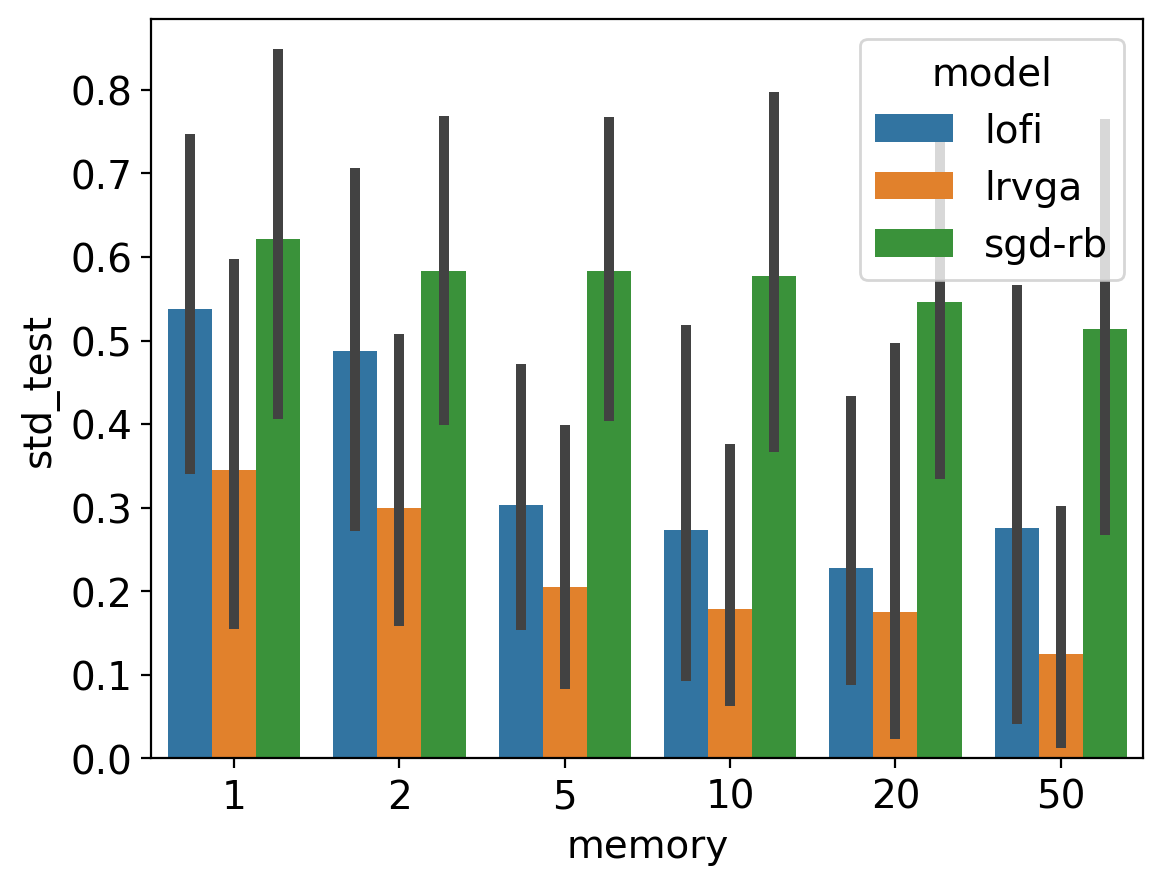

In [12]:
sns.barplot(
    x="memory",
    y="std_test",
    hue="model",
    data=df_all
)

In [21]:
summary = df_all.groupby(["model", "memory"]).mean(numeric_only=True)

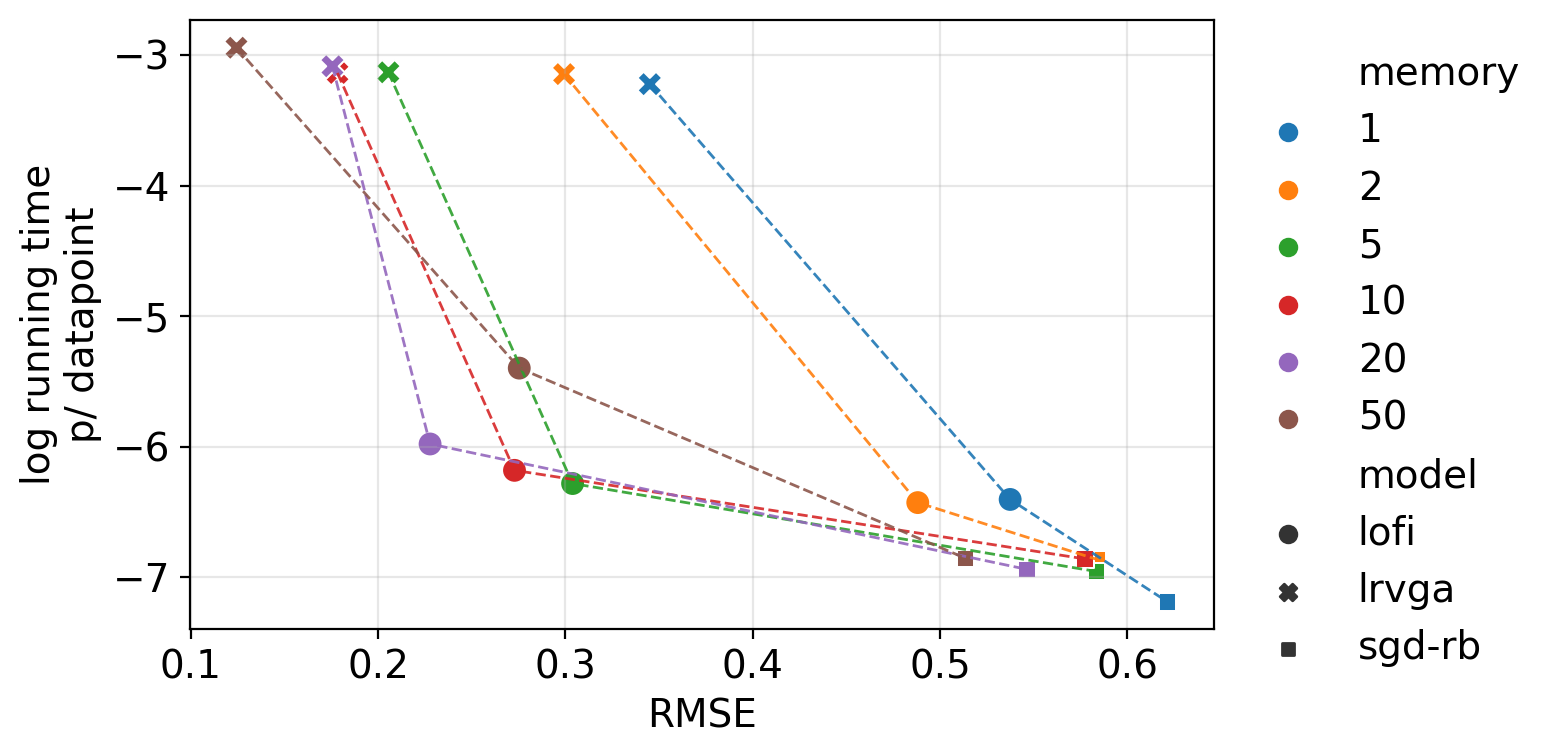

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    y="log_running_time_dp",
    x="std_test",
    style="model",
    hue="memory",
    data=summary,
    ax=ax,
    s=80,
    palette="tab10"
)

colors = jnp.arange(0, 10)
colors = plt.cm.tab10(colors)

sizes_mem =[1, 2, 5, 10, 20, 50]
for k, c in zip(sizes_mem, colors):
    x0, y0 = summary.loc[("lrvga", k), ("std_test", "log_running_time_dp")]
    x1, y1 = summary.loc[("lofi", k), ("std_test", "log_running_time_dp")]
    x2, y2 = summary.loc[("sgd-rb", k), ("std_test", "log_running_time_dp")]

    ax.plot([x0, x1, x2], [y0, y1, y2], c=c, linestyle="--", linewidth=1, alpha=0.9)
plt.ylabel("log running time\np/ datapoint")
plt.xlabel("RMSE")
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/metric-vs-running-time-mean.pdf")
plt.savefig("../figures/metric-vs-running-time-mean.png", dpi=150)

<AxesSubplot: xlabel='RMSE', ylabel='log-running-time\ndatapoint'>

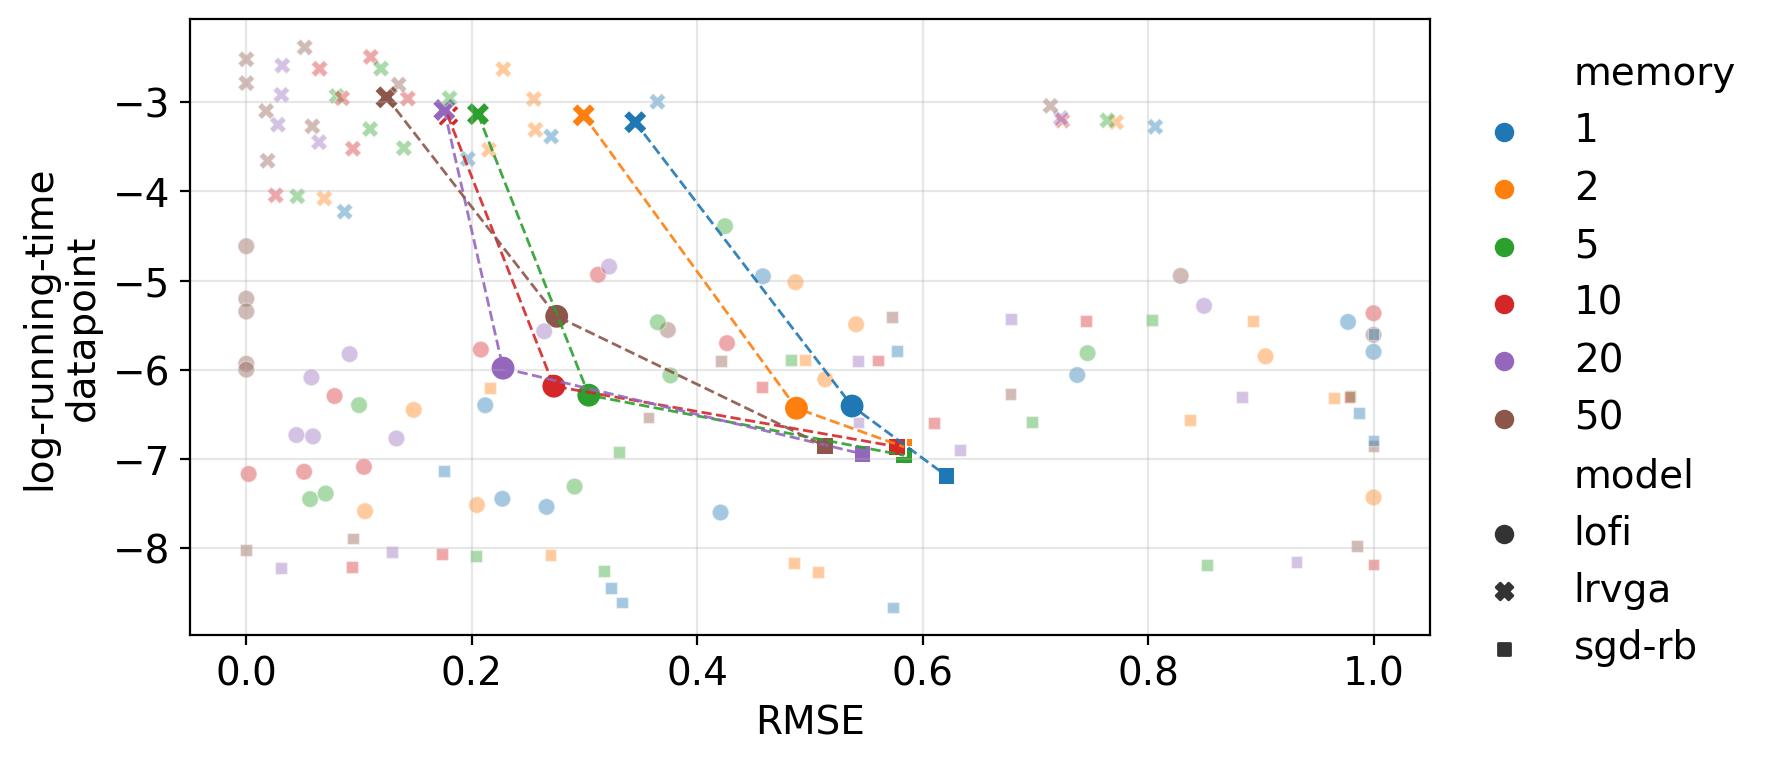

In [606]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    y="log_running_time_dp",
    x="std_test",
    style="model",
    hue="memory",
    data=summary,
    ax=ax,
    s=80,
    palette="tab10"
)

colors = jnp.arange(0, 10)
colors = plt.cm.tab10(colors)

sizes_mem =[1, 2, 5, 10, 20, 50]
for k, c in zip(sizes_mem, colors):
    x0, y0 = summary.loc[("lrvga", k), ("std_test", "log_running_time_dp")]
    x1, y1 = summary.loc[("lofi", k), ("std_test", "log_running_time_dp")]
    x2, y2 = summary.loc[("sgd-rb", k), ("std_test", "log_running_time_dp")]

    ax.plot([x0, x1, x2], [y0, y1, y2], c=c, linestyle="--", linewidth=1, alpha=0.9)
plt.ylabel("log-running-time\ndatapoint")
plt.xlabel("RMSE")
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.grid(alpha=0.3)


sns.scatterplot(
    y="log_running_time_dp",
    x="std_test",
    hue="memory",
    style="model",
    data=df_all,
    ax=ax,
    palette="tab10",
    alpha=0.4,
    legend=False
)